In [49]:
# 0 Housekeeping. Clear variable space
######################################
from IPython import get_ipython  

ipython = get_ipython()
ipython.magic("reset -f")
ipython = get_ipython()
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import folium
from folium.plugins import MarkerCluster
from folium import CircleMarker
from IPython.display import IFrame
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# 1 Import Libraries and Set Global Parameters
##############################################
# 1.1 Import Python Libraries
#############################
from datetime import datetime
print("Run Section 1 Import Libraries and Set Global Parameters...")
begin_time = datetime.now()

import os, sys
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq

Run Section 1 Import Libraries and Set Global Parameters...


In [52]:
# 1.2 Set Global Parameters
###########################
    
if os.getlogin() == "E048374":
    # Working Paths
    path_working = r"C:\Users\E048374\OneDrive - WMATA\rawnav_rachel_fork\WMATA_AVL"
    os.chdir(os.path.join(path_working))
    sys.path.append(r"C:\Users\E048374\OneDrive - WMATA\rawnav_rachel_fork\WMATA_AVL")
    path_source_data = r"\\l-600730\RawNavArchive"
    path_sp = r"C:\Users\E048374\Documents\RawNav"
    path_processed_data = os.path.join(path_working, "data", "02-processed")
    path_segments = os.path.join(path_working, "data", "02-processed")

else:
    raise FileNotFoundError("Define the path_working, path_source_data, gtfs_dir, \
                            ZippedFilesloc, and path_processed_data in a new elif block")

In [53]:
# Globals
# Queue Jump Routes
q_jump_route_list = ['52']
analysis_routes = q_jump_route_list
# EPSG code for WMATA-area work
wmata_crs = 2248
     
# 1.3 Import User-Defined Package
#################################
import wmatarawnav as wr

In [54]:
seg_pattern = pd.read_csv(os.path.join(path_segments,"stop_seq_pattern_5201_by_intersection.csv"),
                         dtype={'route':str, 'PATTERN_ID':str, 'pattern':'int32'})
seg_pattern

seg_name_id  geoid  stop_id route  pattern
0     14th_22      0        0    52        1
1     14th_24      0        0    52        1
2     14th_25   7243    19143    52        1

In [55]:
xwalk_seg_pattern_stop = seg_pattern[['route','pattern','seg_name_id','stop_id']].copy()
xwalk_seg_pattern_stop

route  pattern seg_name_id  stop_id
0    52        1     14th_22        0
1    52        1     14th_24        0
2    52        1     14th_25    19143

# Pick a segment without a stop

In [176]:
# 1 segment
seg = xwalk_seg_pattern_stop.loc[:,'seg_name_id'].values[0]
seg

'14th_22'

In [177]:
# 2. Decompose Travel Time
##########################

# 2.0 Setup exports
###################
freeflow_list = []
stop_area_decomp_list = []
traveltime_decomp_list = []

path_exports = (
    os.path.join(
        path_processed_data,
        "exports_{0}_{1}".format(seg,datetime.now().strftime("%Y%m%d"))
    )
)
if not os.path.isdir(path_exports):
    os.mkdir(path_exports)

In [178]:
print('now on {}'.format(seg))
# 2.1. Read-in Data 
###################
# Reduce rawnav data to runs present in the summary file after filtering.

xwalk_seg_pattern_stop_fil = xwalk_seg_pattern_stop.query('seg_name_id == @seg')

seg_routes = list(xwalk_seg_pattern_stop_fil.route.drop_duplicates())

rawnav_dat = (
    wr.read_cleaned_rawnav(
       analysis_routes_ = seg_routes,
       path = os.path.join(path_processed_data, "rawnav_data.parquet")
    )
    .drop(columns=['blank', 'lat_raw', 'long_raw', 'sat_cnt'])
)

segment_summary = (
    pq.read_table(
        source = os.path.join(path_processed_data,"segment_summary.parquet"),
        filters = [['seg_name_id', "=", seg]],
        use_pandas_metadata = True
    )
    .to_pandas()
)

segment_summary_fil = (
    segment_summary
    .query('~(flag_too_far_any\
              | flag_wrong_order_any\
              | flag_too_long_odom\
              | flag_secs_total_mismatch\
              | flag_odom_total_mismatch)'
    )
)

now on 14th_22


In [179]:
segment_summary_fil.head()

filename  index_run_start  pattern     start_date_time  \
0  rawnav06475190608.txt              0.0        1 2019-06-07 04:22:16   
1  rawnav06475190608.txt           5199.0        1 2019-06-07 07:46:51   
2  rawnav06475190608.txt           8016.0        1 2019-06-07 09:49:41   
3  rawnav06475190608.txt          11220.0        1 2019-06-07 12:00:14   
4  rawnav06475190608.txt          14487.0        1 2019-06-07 14:01:00   

   flag_too_far_any  flag_wrong_order_any  flag_too_long_odom  \
0             False                 False               False   
1             False                 False               False   
2             False                 False               False   
3             False                 False               False   
4             False                 False               False   

   flag_secs_total_mismatch  flag_odom_total_mismatch  start_odom_ft_segment  \
0                     False                     False                11824.0   
1                     False                     False                 7192.0   
2                     False                     False                11797.0   
3                     False                     False                11791.0   
4                     False                     False                11775.0   

   ...  mph_odom  mph_run_tag  dist_crow_fly_mi  lat_start  long_start  \
0  ...  8.876006         8.88          4.941288  38.955735  -77.033127   
1  ...  7.658212         7.66          4.143391  38.944177  -77.032785   
2  ...  7.691515         7.69          4.935974  38.955743  -77.033142   
3  ...  6.465002         6.47          4.930933  38.955748  -77.033112   
4  ...  5.453143         5.45          4.937782  38.955722  -77.033147   

     lat_end   long_end  route    wday  seg_name_id  
0  38.884778 -77.021367     52  Friday      14th_22  
1  38.884870 -77.021175     52  Friday      14th_22  
2  38.884905 -77.020978     52  Friday      14th_22  
3  38.884972 -77.021060     52  Friday      14th_22  
4  38.884867 -77.020893     52  Friday      14th_22  

[5 rows x 50 columns]

In [180]:
segment_summary_fil.iloc[0]

filename                                                     rawnav06475190608.txt
index_run_start                                                                  0
pattern                                                                          1
start_date_time                                                2019-06-07 04:22:16
flag_too_far_any                                                             False
flag_wrong_order_any                                                         False
flag_too_long_odom                                                           False
flag_secs_total_mismatch                                                     False
flag_odom_total_mismatch                                                     False
start_odom_ft_segment                                                        11824
end_odom_ft_segment                                                          12113
trip_dist_mi_odom_and_segment                                                 0.05
star

In [181]:
test_rawnav = rawnav_dat.iloc[:1000].copy()

In [182]:
test_rawnav_gpd = gpd.GeoDataFrame(
                    test_rawnav, 
                    geometry = gpd.points_from_xy(
                        test_rawnav.long,
                        test_rawnav.lat
                    ),
    crs='EPSG:4326'
)

In [183]:
def get_centroid_gpd(gpd_df):
    '''
    '''
    minx = gpd_df.bounds.mean()['minx']
    miny = gpd_df.bounds.mean()['miny']
    maxx = gpd_df.bounds.mean()['maxx']
    maxy = gpd_df.bounds.mean()['maxy']
    avg_x = np.array([minx, maxx]).mean()
    avg_y = np.array([miny, maxy]).mean()
    #return Lat, Long
    return[avg_y, avg_x]

In [184]:
esri_imagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
esri_attribution = \
    "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, " \
    "UPR-EGP, and the GIS User Community"
this_map = folium.Map(location=get_centroid_gpd(test_rawnav_gpd),
                       tiles='cartodbdark_matter', zoom_start=16, max_zoom=25, control_scale=True)
folium.TileLayer(name="EsriImagery", tiles=esri_imagery, attr=esri_attribution,
                 zoom_start=16, max_zoom=25, control_scale=True).add_to(this_map)
folium.TileLayer('cartodbpositron', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)
folium.TileLayer('openstreetmap', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)

h = folium.FeatureGroup(name='stop locations')

wr.plot_marker_clusters(this_map, test_rawnav_gpd, "lat","long",h, fill_color='#f79e19')

this_map.add_child(h)

## filter rawnav to segment 

In [185]:
rawnav_filtered = wr.filter_to_segment(rawnav_dat,
                                     segment_summary_fil)

In [186]:
test_rawnav_filtered = rawnav_filtered.iloc[:1000].copy()

In [187]:
test_rawnav_filtered_gpd = gpd.GeoDataFrame(
                    test_rawnav_filtered, 
                    geometry = gpd.points_from_xy(
                        test_rawnav_filtered.long,
                        test_rawnav_filtered.lat
                    ),
    crs='EPSG:4326'
)

In [188]:
esri_imagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
esri_attribution = \
    "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, " \
    "UPR-EGP, and the GIS User Community"
this_map = folium.Map(location=get_centroid_gpd(test_rawnav_filtered_gpd),
                       tiles='cartodbdark_matter', zoom_start=16, max_zoom=25, control_scale=True)
folium.TileLayer(name="EsriImagery", tiles=esri_imagery, attr=esri_attribution,
                 zoom_start=16, max_zoom=25, control_scale=True).add_to(this_map)
folium.TileLayer('cartodbpositron', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)
folium.TileLayer('openstreetmap', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)

h = folium.FeatureGroup(name='stop locations')

wr.plot_marker_clusters(this_map, test_rawnav_filtered_gpd, "lat","long",h, fill_color='#f79e19')

this_map.add_child(h)

## decomposition 

## two ways to calculate free flow
free flow every 3 GPS points or free flow based on start/end segment 

benefit of start/end is that you avoid looking at every GPS point for street segments without a stop

In [195]:
(segment_summary_fil
 .loc[:,'trip_speed_mph_segment']
 .quantile([0.01, 0.05, 0.10, 0.15, 0.25, 0.5, 0.75, 0.85, 0.90, 0.95, 0.99]))

0.01     4.7200
0.05     5.4600
0.10     6.3900
0.15     7.7075
0.25    17.5175
0.50    20.2850
0.75    23.2775
0.85    24.8775
0.90    25.6650
0.95    26.7300
0.99    29.8945
Name: trip_speed_mph_segment, dtype: float64

In [189]:
freeflow_seg = wr.decompose_segment_ff(rawnav_dat, segment_summary_fil)
freeflow_seg

fps_next3        mph
0.01   1.695667   1.155874
0.05   3.945833   2.689730
0.10  11.000000   7.498296
0.15  15.666667  10.679391
0.25  21.000000  14.314928
0.50  28.333333  19.313792
0.75  33.500000  22.835719
0.85  35.666667  24.312656
0.90  37.500000  25.562372
0.95  40.000000  27.266530
0.99  46.000000  31.356510

In [190]:
segment_ff_val = (
    freeflow_seg
    .loc[0.95]
    .loc["fps_next3"]
)
segment_ff_val

40.0

In [191]:
rawnav_fil_seg = wr.calc_rolling_vals(rawnav_dat)

rawnav_fil_seg = wr.filter_to_segment(rawnav_fil_seg,
                                   segment_summary_fil)

totals = (
    rawnav_fil_seg
    .groupby(['filename','index_run_start'])
    .agg({"odom_ft": [lambda x: max(x) - min(x)],
          "sec_past_st" : [lambda x: max(x) - min(x)]})
    .pipe(wr.reset_col_names)
    .rename(columns = {'odom_ft_<lambda>': 'odom_ft_seg_total',
                       'sec_past_st_<lambda>':'t_segment'})
)

In [192]:
totals.loc[:,'ff_fps'] = segment_ff_val
totals.loc[:,'t_ff'] = totals.loc[:,['ff_fps','odom_ft_seg_total']].apply(lambda x: 
                                                                          x['odom_ft_seg_total']/x['ff_fps']
                                                                    ,axis=1)
totals.loc[:,'t_traffic'] = totals.loc[:,['t_ff','t_segment']].apply(lambda x: 
                                                                     0 if x['t_segment']-x['t_ff']<0
                                                                     else x['t_segment']-x['t_ff']
                                                                    ,axis=1)

totals.loc[:,'seg_name_id'] = seg
totals.loc[:,'t_stop'] = 0
totals.loc[:,'t_stop1'] = 0
totals.loc[:,'t_stop2'] = 0

segment_part1 = totals[['filename', 'index_run_start', 'odom_ft_seg_total', 't_segment',
       't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']].copy()
segment_part1.head(5)

filename  index_run_start  odom_ft_seg_total  t_segment  \
0  rawnav06473190603.txt              0.0              274.0        7.0   
1  rawnav06473190611.txt           6693.0              280.0        7.0   
2  rawnav06473190611.txt           9490.0              263.0        7.0   
3  rawnav06473190611.txt          12013.0              280.0        9.0   
4  rawnav06474190609.txt            133.0              261.0        9.0   

    t_ff  t_stop  t_stop1  t_stop2  t_traffic seg_name_id  
0  6.850       0        0        0      0.150     14th_22  
1  7.000       0        0        0      0.000     14th_22  
2  6.575       0        0        0      0.425     14th_22  
3  7.000       0        0        0      2.000     14th_22  
4  6.525       0        0        0      2.475     14th_22

In [193]:
segment_part1.head(10)

filename  index_run_start  odom_ft_seg_total  t_segment  \
0  rawnav06473190603.txt              0.0              274.0        7.0   
1  rawnav06473190611.txt           6693.0              280.0        7.0   
2  rawnav06473190611.txt           9490.0              263.0        7.0   
3  rawnav06473190611.txt          12013.0              280.0        9.0   
4  rawnav06474190609.txt            133.0              261.0        9.0   
5  rawnav06474190611.txt           2249.0              281.0       38.0   
6  rawnav06474190611.txt           5694.0              273.0       31.0   
7  rawnav06474190611.txt           8706.0              275.0        8.0   
8  rawnav06474190611.txt          11983.0              309.0       11.0   
9  rawnav06474190611.txt          15717.0              282.0       10.0   

    t_ff  t_stop  t_stop1  t_stop2  t_traffic seg_name_id  
0  6.850       0        0        0      0.150     14th_22  
1  7.000       0        0        0      0.000     14th_22  
2  6.575       0        0        0      0.425     14th_22  
3  7.000       0        0        0      2.000     14th_22  
4  6.525       0        0        0      2.475     14th_22  
5  7.025       0        0        0     30.975     14th_22  
6  6.825       0        0        0     24.175     14th_22  
7  6.875       0        0        0      1.125     14th_22  
8  7.725       0        0        0      3.275     14th_22  
9  7.050       0        0        0      2.950     14th_22

In [194]:
segment_summary_fil[(segment_summary_fil.loc[:,'filename']=='rawnav06474190611.txt')
&(segment_summary_fil.loc[:,'index_run_start']==5694.0)]['trip_dur_sec_segment']

2    31.0
Name: trip_dur_sec_segment, dtype: float64

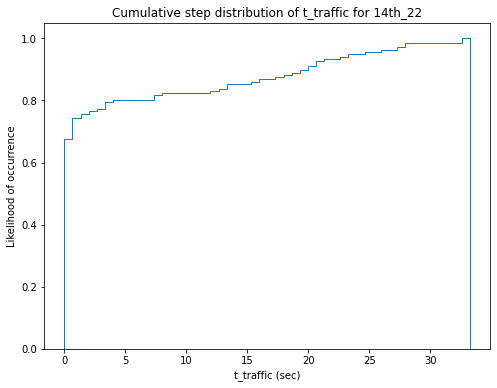

In [122]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(segment_part1.loc[:,'t_traffic'].values, bins=50, density=True, cumulative=True, histtype='step')
ax.set_title(f'Cumulative step distribution of t_traffic for {seg}')
ax.set_xlabel('t_traffic (sec)')
_=ax.set_ylabel('Likelihood of occurrence')

# Pick a segment with a stop

In [81]:
xwalk_seg_pattern_stop

route  pattern seg_name_id  stop_id
0    52        1     14th_22        0
1    52        1     14th_24        0
2    52        1     14th_25    19143

In [133]:
# 1 segment
seg = xwalk_seg_pattern_stop.loc[:,'seg_name_id'].values[2]
seg

'14th_25'

In [134]:
# 2. Decompose Travel Time
##########################

# 2.0 Setup exports
###################
freeflow_list = []
stop_area_decomp_list = []
traveltime_decomp_list = []

path_exports = (
    os.path.join(
        path_processed_data,
        "exports_{0}_{1}".format(seg,datetime.now().strftime("%Y%m%d"))
    )
)
if not os.path.isdir(path_exports):
    os.mkdir(path_exports)

In [135]:
print('now on {}'.format(seg))
# 2.1. Read-in Data 
###################
# Reduce rawnav data to runs present in the summary file after filtering.

xwalk_seg_pattern_stop_fil = xwalk_seg_pattern_stop.query('seg_name_id == @seg')

seg_routes = list(xwalk_seg_pattern_stop_fil.route.drop_duplicates())

rawnav_dat = (
    wr.read_cleaned_rawnav(
       analysis_routes_ = seg_routes,
       path = os.path.join(path_processed_data, "rawnav_data.parquet")
    )
    .drop(columns=['blank', 'lat_raw', 'long_raw', 'sat_cnt'])
)

segment_summary = (
    pq.read_table(
        source = os.path.join(path_processed_data,"segment_summary.parquet"),
        filters = [['seg_name_id', "=", seg]],
        use_pandas_metadata = True
    )
    .to_pandas()
)

segment_summary_fil = (
    segment_summary
    .query('~(flag_too_far_any\
              | flag_wrong_order_any\
              | flag_too_long_odom\
              | flag_secs_total_mismatch\
              | flag_odom_total_mismatch)'
    )
)

now on 14th_25


## also need stop index

In [136]:
stop_index = ( pq.read_table(source=os.path.join(path_processed_data,"stop_index.parquet"),
                  filters=[[('route','=',route)] for route in seg_routes],
                    columns = [ 'route',
                                'pattern',
                                'stop_id',
                                'filename',
                                'index_run_start',
                                'index_loc',
                                'odom_ft',
                                'sec_past_st',
                                'geo_description'],
                  use_pandas_metadata = True
    ).to_pandas()
        # As a bit of proofing, we confirm this is int32 and not string, may remove later
        .assign(pattern = lambda x: x.pattern.astype('int32'))
        .assign(route = lambda x: x.route.astype(str))
        .rename(columns = {'odom_ft' : 'odom_ft_qj_stop'})
    )

stop_index_fil = (
        stop_index
        .merge(xwalk_seg_pattern_stop_fil,
               on = ['route','pattern','stop_id'],
               how = 'inner')   
    )

In [137]:
stop_index_fil.head(3)

route  pattern  stop_id               filename  index_run_start  index_loc  \
0    52        1    19143  rawnav06475190608.txt              0.0      476.0   
1    52        1    19143  rawnav06475190608.txt           5199.0     5525.0   
2    52        1    19143  rawnav06475190608.txt           8016.0     8582.0   

   odom_ft_qj_stop  sec_past_st        geo_description seg_name_id  
0          12291.0        879.0  14TH ST + FAIRMONT ST     14th_25  
1           7674.0        537.0  14TH ST + FAIRMONT ST     14th_25  
2          12281.0        977.0  14TH ST + FAIRMONT ST     14th_25

In [138]:
segment_summary_fil.head()

filename  index_run_start  pattern     start_date_time  \
0  rawnav06475190608.txt              0.0        1 2019-06-07 04:22:16   
1  rawnav06475190608.txt           5199.0        1 2019-06-07 07:46:51   
2  rawnav06475190608.txt           8016.0        1 2019-06-07 09:49:41   
3  rawnav06475190608.txt          11220.0        1 2019-06-07 12:00:14   
4  rawnav06475190608.txt          14487.0        1 2019-06-07 14:01:00   

   flag_too_far_any  flag_wrong_order_any  flag_too_long_odom  \
0             False                 False               False   
1             False                 False               False   
2             False                 False               False   
3             False                 False               False   
4             False                 False               False   

   flag_secs_total_mismatch  flag_odom_total_mismatch  start_odom_ft_segment  \
0                     False                     False                12191.0   
1                     False                     False                 7580.0   
2                     False                     False                12165.0   
3                     False                     False                12175.0   
4                     False                     False                12164.0   

   ...  mph_odom  mph_run_tag  dist_crow_fly_mi  lat_start  long_start  \
0  ...  8.876006         8.88          4.941288  38.955735  -77.033127   
1  ...  7.658212         7.66          4.143391  38.944177  -77.032785   
2  ...  7.691515         7.69          4.935974  38.955743  -77.033142   
3  ...  6.465002         6.47          4.930933  38.955748  -77.033112   
4  ...  5.453143         5.45          4.937782  38.955722  -77.033147   

     lat_end   long_end  route    wday  seg_name_id  
0  38.884778 -77.021367     52  Friday      14th_25  
1  38.884870 -77.021175     52  Friday      14th_25  
2  38.884905 -77.020978     52  Friday      14th_25  
3  38.884972 -77.021060     52  Friday      14th_25  
4  38.884867 -77.020893     52  Friday      14th_25  

[5 rows x 50 columns]

In [139]:
test_rawnav = rawnav_dat.iloc[:1000].copy()

In [140]:
test_rawnav_gpd = gpd.GeoDataFrame(
                    test_rawnav, 
                    geometry = gpd.points_from_xy(
                        test_rawnav.long,
                        test_rawnav.lat
                    ),
    crs='EPSG:4326'
)

In [141]:
def get_centroid_gpd(gpd_df):
    '''
    '''
    minx = gpd_df.bounds.mean()['minx']
    miny = gpd_df.bounds.mean()['miny']
    maxx = gpd_df.bounds.mean()['maxx']
    maxy = gpd_df.bounds.mean()['maxy']
    avg_x = np.array([minx, maxx]).mean()
    avg_y = np.array([miny, maxy]).mean()
    #return Lat, Long
    return[avg_y, avg_x]

In [142]:
esri_imagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
esri_attribution = \
    "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, " \
    "UPR-EGP, and the GIS User Community"
this_map = folium.Map(location=get_centroid_gpd(test_rawnav_gpd),
                       tiles='cartodbdark_matter', zoom_start=16, max_zoom=25, control_scale=True)
folium.TileLayer(name="EsriImagery", tiles=esri_imagery, attr=esri_attribution,
                 zoom_start=16, max_zoom=25, control_scale=True).add_to(this_map)
folium.TileLayer('cartodbpositron', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)
folium.TileLayer('openstreetmap', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)

h = folium.FeatureGroup(name='stop locations')

wr.plot_marker_clusters(this_map, test_rawnav_gpd, "lat","long",h, fill_color='#f79e19')

this_map.add_child(h)

## filter rawnav to segment 

In [143]:
rawnav_filtered = wr.filter_to_segment(rawnav_dat,
                                     segment_summary_fil)

In [144]:
test_rawnav_filtered = rawnav_filtered.iloc[:1000].copy()

In [145]:
test_rawnav_filtered_gpd = gpd.GeoDataFrame(
                    test_rawnav_filtered, 
                    geometry = gpd.points_from_xy(
                        test_rawnav_filtered.long,
                        test_rawnav_filtered.lat
                    ),
    crs='EPSG:4326'
)

In [146]:
esri_imagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
esri_attribution = \
    "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, " \
    "UPR-EGP, and the GIS User Community"
this_map = folium.Map(location=get_centroid_gpd(test_rawnav_filtered_gpd),
                       tiles='cartodbdark_matter', zoom_start=16, max_zoom=25, control_scale=True)
folium.TileLayer(name="EsriImagery", tiles=esri_imagery, attr=esri_attribution,
                 zoom_start=16, max_zoom=25, control_scale=True).add_to(this_map)
folium.TileLayer('cartodbpositron', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)
folium.TileLayer('openstreetmap', zoom_start=16, max_zoom=20, control_scale=True).add_to(this_map)

h = folium.FeatureGroup(name='stop locations')

wr.plot_marker_clusters(this_map, test_rawnav_filtered_gpd, "lat","long",h, fill_color='#f79e19')

this_map.add_child(h)

## decomposition 

In [147]:
# Calculate Free Flow Travel Time through Entire Segment
segment_ff = (
    wr.decompose_segment_ff(
        rawnav_dat,
        segment_summary_fil,
        max_fps = 73.3
    )
    .assign(seg_name_id = seg)
)

freeflow_list.append(segment_ff)

# Calculate Stop-Area Decomposition
stop_area_decomp = (
    wr.decompose_stop_area(
        rawnav_dat,
        segment_summary_fil,
        stop_index_fil
    )
    .assign(seg_name_id = seg)
)

stop_area_decomp_list.append(stop_area_decomp)

segment_ff_val = (
    segment_ff
    .loc[0.95]
    .loc["fps_next3"]
)

# Run decomposition
traveltime_decomp = (
    wr.decompose_traveltime(
        rawnav_dat,
        segment_summary_fil,
        stop_area_decomp,
        segment_ff_val
    )
)
traveltime_decomp_list.append(traveltime_decomp)

In [148]:
freeflow = (
    pd.concat(freeflow_list)
    .rename_axis('ntile')
    .reset_index()
)

basic_decomp = (
    pd.concat(stop_area_decomp_list)
    .reset_index() 
)

traveltime_decomp = (
    pd.concat(traveltime_decomp_list)
    .reset_index()
)

In [149]:
freeflow.to_csv(os.path.join(path_exports,"freeflow.csv"))

basic_decomp.to_csv(os.path.join(path_exports,"basic_decomp.csv"))

traveltime_decomp.to_csv(os.path.join(path_exports,"traveltime_decomp.csv"))

In [150]:
traveltime_decomp.head()

index               filename  index_run_start seg_name_id  route  pattern  \
0      0  rawnav06475190608.txt              0.0     14th_25     52        1   
1      1  rawnav06475190608.txt           5199.0     14th_25     52        1   
2      2  rawnav06475190608.txt           8016.0     14th_25     52        1   
3      3  rawnav06475190608.txt          11220.0     14th_25     52        1   
4      4  rawnav06475190608.txt          14487.0     14th_25     52        1   

     wday     start_date_time  flag_nostop  t_segment  ...  \
0  Friday 2019-06-07 04:22:16        False       36.0  ...   
1  Friday 2019-06-07 07:46:51        False       70.0  ...   
2  Friday 2019-06-07 09:49:41        False       28.0  ...   
3  Friday 2019-06-07 12:00:14        False       39.0  ...   
4  Friday 2019-06-07 14:01:00        False       89.0  ...   

   run_duration_from_tags  dist_odom_mi  mph_odom  mph_run_tag  \
0         0 days 00:45:01      6.659470  8.876006         8.88   
1         0 days 00:45:15      5.775568  7.658212         7.66   
2         0 days 00:51:48      6.640341  7.691515         7.69   
3         0 days 01:01:35      6.635606  6.465002         6.47   
4         0 days 01:12:57      6.630114  5.453143         5.45   

   dist_crow_fly_mi  lat_start  long_start    lat_end   long_end  \
0          4.941288  38.955735  -77.033127  38.884778 -77.021367   
1          4.143391  38.944177  -77.032785  38.884870 -77.021175   
2          4.935974  38.955743  -77.033142  38.884905 -77.020978   
3          4.930933  38.955748  -77.033112  38.884972 -77.021060   
4          4.937782  38.955722  -77.033147  38.884867 -77.020893   

   odom_ft_seg_total  
0              293.0  
1              296.0  
2              309.0  
3              273.0  
4              286.0  

[5 rows x 62 columns]

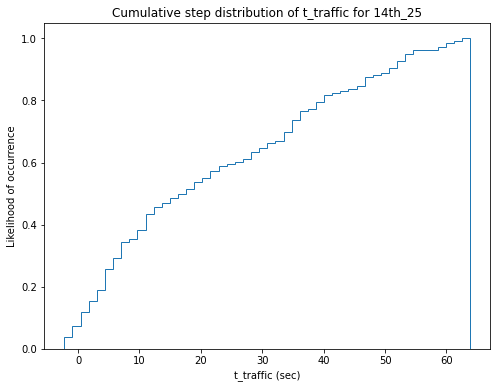

In [151]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(traveltime_decomp.loc[:,'t_traffic'].values, bins=50, density=True, cumulative=True, histtype='step')
ax.set_title(f'Cumulative step distribution of t_traffic for {seg}')
ax.set_xlabel('t_traffic (sec)')
_=ax.set_ylabel('Likelihood of occurrence')

# combine segments

In [154]:
traveltime_decomp.loc[:,'t_traffic'] = traveltime_decomp.loc[:,'t_traffic'].apply(lambda x: 0 if x<0 else x)
segment_part2 = traveltime_decomp[['filename', 'index_run_start', 'odom_ft_seg_total', 't_segment',
       't_ff', 't_stop','t_stop1','t_stop2','t_traffic', 'seg_name_id']].copy()

segment_part2.head()

filename  index_run_start  odom_ft_seg_total  t_segment  \
0  rawnav06475190608.txt              0.0              293.0       36.0   
1  rawnav06475190608.txt           5199.0              296.0       70.0   
2  rawnav06475190608.txt           8016.0              309.0       28.0   
3  rawnav06475190608.txt          11220.0              273.0       39.0   
4  rawnav06475190608.txt          14487.0              286.0       89.0   

        t_ff  t_stop  t_stop1    t_stop2  t_traffic seg_name_id  
0   9.876404     0.0      2.0  11.643538  12.480057     14th_25  
1   9.977528     0.0     14.0  11.643538  34.378934     14th_25  
2  10.415730     0.0      4.0   8.643538   4.940731     14th_25  
3   9.202247     0.0     14.0   8.643538   7.154214     14th_25  
4   9.640449     0.0     36.0   8.643538  34.716012     14th_25

In [156]:
combine_segments = segment_part1.append(segment_part2)

In [168]:
combine_segments.sort_values(['filename','index_run_start']).head(8)

filename  index_run_start  odom_ft_seg_total  t_segment  \
0    rawnav06473190603.txt              0.0              274.0        7.0   
71   rawnav06473190603.txt              0.0              294.0        9.0   
1    rawnav06473190611.txt           6693.0              280.0        7.0   
34   rawnav06473190611.txt           6693.0              309.0       58.0   
2    rawnav06473190611.txt           9490.0              263.0        7.0   
103  rawnav06473190611.txt           9490.0              270.0        7.0   
3    rawnav06473190611.txt          12013.0              280.0        9.0   
104  rawnav06473190611.txt          12013.0              304.0       22.0   

          t_ff  t_stop  t_stop1   t_stop2  t_traffic seg_name_id  
0     9.235955     0.0      0.0  0.000000   0.000000     14th_22  
71    9.910112     0.0      0.0  0.000000   0.000000     14th_25  
1     9.438202     0.0      0.0  0.000000   0.000000     14th_22  
34   10.415730     0.0      3.0  8.643538  35.940731     14th_25  
2     8.865169     0.0      0.0  0.000000   0.000000     14th_22  
103   9.101124     0.0      0.0  0.000000   0.000000     14th_25  
3     9.438202     0.0      0.0  0.000000   0.000000     14th_22  
104  10.247191     0.0      0.0  0.000000  11.752809     14th_25

In [157]:
combine_segments[(combine_segments.loc[:,'filename']=='rawnav06475190608.txt')
&(combine_segments.loc[:,'index_run_start']==5199)]

filename  index_run_start  odom_ft_seg_total  t_segment  \
12  rawnav06475190608.txt           5199.0              320.0       11.0   
1   rawnav06475190608.txt           5199.0              296.0       70.0   

         t_ff  t_stop  t_stop1    t_stop2  t_traffic seg_name_id  
12  10.786517     0.0      0.0   0.000000   0.213483     14th_22  
1    9.977528     0.0     14.0  11.643538  34.378934     14th_25

In [159]:
combine_segments_grp = combine_segments.groupby(['filename','index_run_start']).agg({'t_traffic':sum}).reset_index()

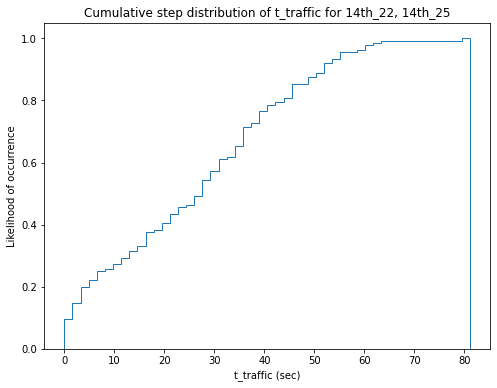

In [165]:
fig, ax = plt.subplots(figsize=(8, 6))
seg_id_str = ", ".join(combine_segments.loc[:,'seg_name_id'].unique().tolist())
ax.hist(combine_segments_grp.loc[:,'t_traffic'].values, bins=50, density=True, cumulative=True, histtype='step')
ax.set_title(f'Cumulative step distribution of t_traffic for {seg_id_str}')
ax.set_xlabel('t_traffic (sec)')
_=ax.set_ylabel('Likelihood of occurrence')